# Determining intrinsic $P(k)$ from gridded tracer particles

[Jing 1995](http://adsabs.harvard.edu/abs/2005ApJ...620..559J) worked out how to determine the true power $P(k)$ from a gridded Fourier transform.

In [2]:
# Import some routines
%matplotlib inline
from array_io import *
import numpy as np
import matplotlib.pyplot as plt
from read_grid_fft import *

# Use Triangular Shaped Cloud Interpolation

## Plot the distribution of particle positions in x-y plane

## Plot the tracer particles, interpolated onto a grid

(64, 64, 64)


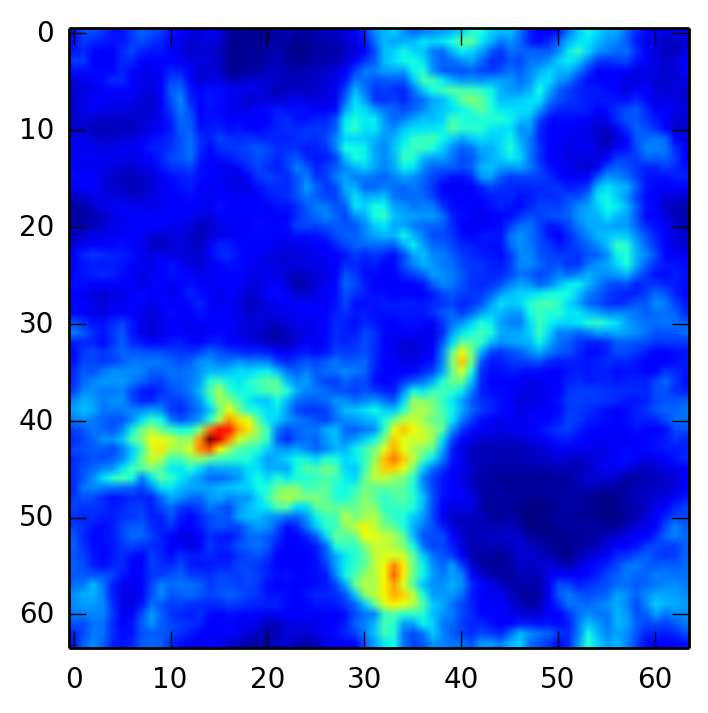

In [8]:
#Read in the three dimensional grid, and project it into 2 dimensions
isnap = 750
ngrid = 64
fdir = "./"
fname = fdir+"tsc.turbulence.%04d.%d.dat" % (isnap,ngrid)
nx,ny,nz,ixmin,ixmax,iymin,iymax,izmin,izmax,ngp = read_grid_fft(fname)
print (nx,ny,nz)
ngpp = np.zeros([nx,ny])
for i in range(ixmin,ixmax,1):
    for j in range(iymin,iymax,1):
        ngpp[i,j] = np.sum(ngp[i,j,:])

plt.imshow(ngpp.T)

## Plot the 3D Fourier amplitudes $\delta^f(\vec{k})$, projected into 2D

I'll first plot NGP, then CIC, then TSC to show the difference.

(64, 64, 64)


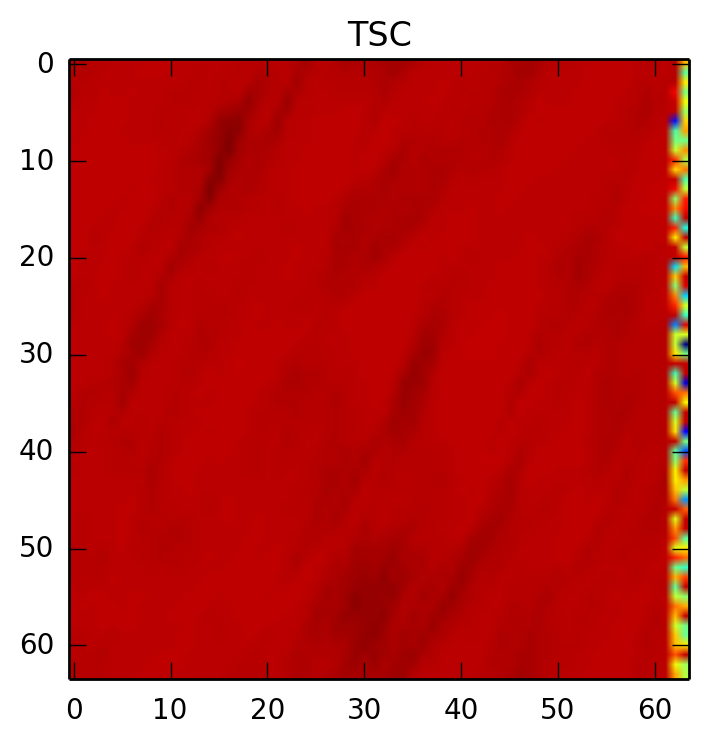

In [7]:
#Read in a delta^f_k grid
isnap = 750
ngrid = 64
fdir = "./"
fname = fdir+"dfk.turbulence.%04d.%d.dat" % (isnap,ngrid)
nx,ny,nz,ixmin,ixmax,iymin,iymax,izmin,izmax,dfk = read_grid_fft(fname)
print(nx,ny,nz)
dfkp = np.zeros([nx,ny])
for i in range(ixmin,ixmax,1):
    for j in range(iymin,iymax,1):
        dfkp[i,j] = np.sum(dfk[i,j,:])
plt.title(r'TSC')
plt.imshow(dfkp.T)

## Perform the $P(k)$ estimation method of Jing (2005).

In [5]:
#define the window function
#equation 18 of Jing 2005

import numpy as np
def Wkp(i,j,k,kN,p):
    if(i==0):
        A = 1.
    else:
        x = 0.5*np.pi*i/kN
        A = np.sin(x)/x
    if(j==0):
        B = 1.
    else:
        y = 0.5*np.pi*j/kN
        B = np.sin(y)/y
    if(k==0):
        C = 1.
    else:
        z = 0.5*np.pi*k/kN
        C = np.sin(z)/z
    #print (x,y,z,A,B,C)
    return (A*B*C)**p

In [6]:
#define the shotnoise term D^2(k) = C_1(k)/N
#equation 20 of Jing 2005

def C1k(i,j,k,kN,p):
  C1k = 0.0
  if(p==1):
    C1out = 1.0
  elif(p==2):
    C1k =  1.0 - (2./3.)*np.sin(0.5*np.pi*i/kN)**2
    C1k *= 1.0 - (2./3.)*np.sin(0.5*np.pi*j/kN)**2
    C1k *= 1.0 - (2./3.)*np.sin(0.5*np.pi*k/kN)**2
  elif(p==3):
    C1k =  1.0 - np.sin(0.5*np.pi*i/kN)**2 + (2./15.)*np.sin(0.5*np.pi*i/kN)**4
    C1k *= 1.0 - np.sin(0.5*np.pi*j/kN)**2 + (2./15.)*np.sin(0.5*np.pi*j/kN)**4
    C1k *= 1.0 - np.sin(0.5*np.pi*k/kN)**2 + (2./15.)*np.sin(0.5*np.pi*k/kN)**4

  return C1k

In [10]:
#define a Power law power spectrum
#see section 3 of Jing 2005

def Pplaw(k,kN,A,alpha):
    return A*(k/kN)**alpha

## Estimate $P(k)$ by iteratively correcting the power spectrum for the window function

In [19]:
#Read in a delta^f_k grid
isnap = 750
ngrid = 64
fdir = "./"

write_flag = 1

#get N
N = 512**3

#set the interpolation
#p = 1.0 #NGP
#p = 2.0 #CIC
p = 3.0 #TSC

#set our fractional tolerance on the power law slope
tol = 1.0e-3

#create dfk^2 array
fname = fdir+"dfk.turbulence.%04d.%d.dat" % (isnap,ngrid)
nx,ny,nz,ixmin,ixmax,iymin,iymax,izmin,izmax,dfk = read_grid_fft(fname)
kN = 0.5*float(nx)


nk = nz/2 + 1
print(nk)
nk_array = np.zeros(nk)
Pr_array = np.zeros(nk)
dfk_only_array = np.zeros(nk)


#make an array of wavenumbers
k_array = np.arange(nk) / float(nk-1)


#compute <<|d^f(k)|^2> - D^2(k)>
for i in range(0,nx/2+1):
    for j in range(0,ny/2+1):
        for k in range(0,nz/2+1):
            if( int((i*i + j*j + k*k)**0.5) <= nz/2 ):
                kk = (i*i + j*j + k*k)**0.5
                #print kk, int(kk), nz/2
                nk_array[kk] += 1.0
                Pr_array[kk] += dfk[i,j,k] - C1k(i,j,k,kN,p)/float(N)
                dfk_only_array[kk] += dfk[i,j,k]

Pr_array /= nk_array
dfk_only_array /= nk_array


#########################################################
#OK, dfk_only_array has been averaged over angle at this point
#begin iterative procedure

#first, compute power-law fit to Pr_array
lnk  = np.log(k_array)
lnPr = np.log(Pr_array)

ki = np.where( (k_array>=0.5)&(k_array<=1.0) )[0]
print ki

pfit = np.polyfit(lnk[ki],lnPr[ki],1)
print pfit

#store initial power law fit
beta = pfit[0]
B = np.exp(pfit[1])
print(B,beta)

#next, compute C2(k) assuming power law for Pk
kipl = np.where(k_array>0)[0]
Pkpl = np.zeros(nk)
Pkpl[kipl] = np.exp(np.poly1d(pfit)(np.log(k_array[kipl])))
    
#iterate until convergence
P0  = np.zeros(nk)
count = 0
flag  = 1
while (flag):
    A = B
    alpha = beta
    C2k = np.zeros(nk)
    n0_array = np.zeros(nk)
    print("iteration %d..." % (count))


    for i in range(0,nx/2+1):
        for j in range(0,ny/2+1):
            for k in range(0,nz/2+1):
                if( int((i*i + j*j + k*k)**0.5) <= nz/2 ):
                    kk = (i*i + j*j + k*k)**0.5
                    if(kk>0):
                        n0_array[kk] += 1.0
                        for n in range(10):
                            #we add in the direction of kk
                            C2k[kk] += Wkp(i+2*kN*n*i/kk,j+2*kN*n*j/kk,k+2*kN*n*k/kk,kN,p)**2 * Pplaw(kk + 2*kN*n,kN,A,alpha)
                
                
    #renormalize C2k by P(k)
    C2k /= n0_array
    C2k /= Pplaw(k_array,1.,A,alpha)
    C2k[0] = 1.
    
    #get the updated P0
    P0[:] = Pr_array[:]/C2k[:]


    #Now fit alpha again
    lnk  = np.log(k_array)
    lnP0 = np.log(P0)
    ki = np.where( (k_array>=0.5)&(k_array<=1.0) )[0]

    pfit = np.polyfit(lnk[ki],lnP0[ki],1)
    beta = pfit[0]
    B = np.exp(pfit[1])
    dalpha = (beta-alpha)/beta
    print(A,alpha,B,beta,dalpha)

    #prevent infinite iterations
    count += 1
    if(count>10):
        flag = 0
    
    #if alpha changes by a small tolerance, then break
    if(np.abs(dalpha)<tol):
        flag = 0


#print the final result
print ("Final slope is alpha = %f, dalpha = %f" % (alpha,dalpha))

#P0 now contains our estimate of the power spectrum
if(write_flag!=0):
    fname_out = "Pk.turbulence.%04d.%d.txt" % (isnap,ngrid)
    out = write_three_arrays(fname_out,k_array,Pr_array,P0)

33


/Library/Python/2.7/site-packages/ipykernel/__main__.py:43: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Library/Python/2.7/site-packages/ipykernel/__main__.py:44: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Library/Python/2.7/site-packages/ipykernel/__main__.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Library/Python/2.7/site-packages/ipykernel/__main__.py:56: RuntimeWarning: divide by zero encountered in log
/Library/Python/2.7/site-packages/ipykernel/__main__.py:57: RuntimeWarning: invalid value encountered in log
/Library/Python/2.7/site-packages/ipykernel/__main__.py:93: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Library/Python/2.7/site-packages/ipykernel/__main__.py:96: VisibleDeprecationWarning

[16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32]
[ -5.34779284 -15.22694182]
(2.4379410027991367e-07, -5.3477928408534741)
iteration 0...


/Library/Python/2.7/site-packages/ipykernel/__main__.py:100: RuntimeWarning: invalid value encountered in divide
/Library/Python/2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in power
/Library/Python/2.7/site-packages/ipykernel/__main__.py:109: RuntimeWarning: divide by zero encountered in log
/Library/Python/2.7/site-packages/ipykernel/__main__.py:110: RuntimeWarning: invalid value encountered in log


(2.4379410027991367e-07, -5.3477928408534741, 3.0565205502745823e-06, -2.5453877385808177, -1.1009737572772071)
iteration 1...
(3.0565205502745823e-06, -2.5453877385808177, 2.9417661800437049e-06, -2.4951524747176625, -0.020133143914918255)
iteration 2...
(2.9417661800437049e-06, -2.4951524747176625, 2.9397353582629183e-06, -2.4942303615597585, -0.00036969847377183921)
Final slope is alpha = -2.495152, dalpha = -0.000370


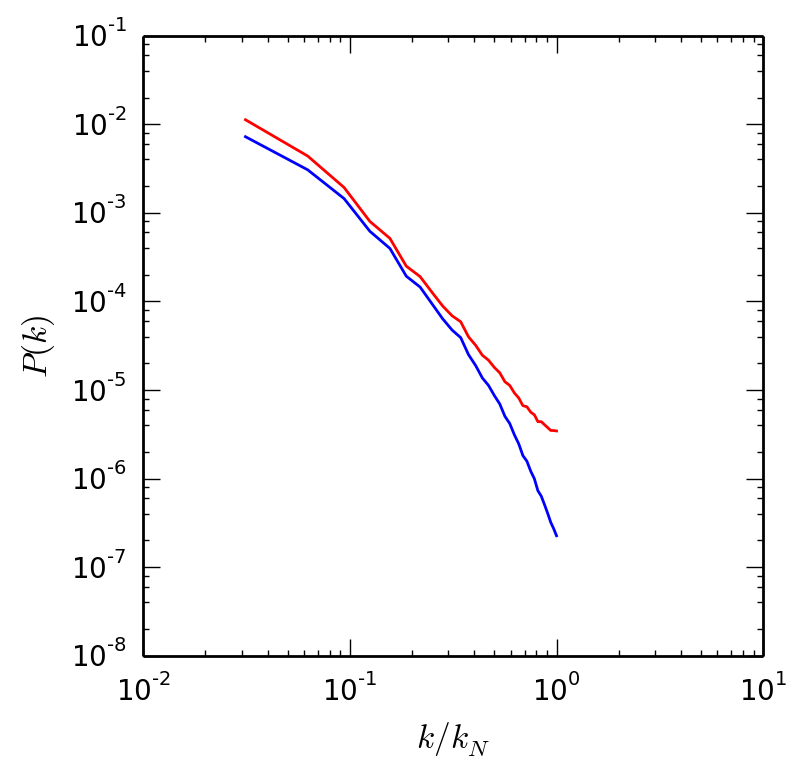

In [20]:
#Begin the figure
fig = plt.figure()
ax = fig.gca()

plt.plot(k_array,Pr_array,'blue')
plt.plot(k_array,P0,color="red")                    


plt.ylim([1.0e-8,1.0e-1])
plt.xlim([0.01,10])
plt.yscale('log')
plt.xscale('log')
plt.axes().set_aspect('0.42857142857142855')
plt.ylabel(r'$P(k)$')
plt.xlabel(r'$k/k_{N}$')
#print Pr_array/nk_array * float(N)